<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
## drop unnecessary id column
df.drop(['id'], axis=1, inplace=True)

##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)



<h4>Imputing

In [4]:
m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

<h4>Binning

In [5]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

<h4>Mapping

In [6]:
residence_type_map = {
    'urban':0,
    'rural':1
}
df['residence_type'] = df['residence_type'].map(residence_type_map)

<h4>Create Dummy DataFrame

In [7]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})

df_dummies = pd.DataFrame(index=df.index)
add_dummy(df_dummies, df, 'work_type')
add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
add_dummy(df_dummies, df, 'bmi_bin')
to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
df_dummies[to_add] = df[to_add]

df_dummies.head()

,wo_self-employed,wo_children,wo_govt-job,wo_never-worked,sm_unknown,sm_formerly-smoked,sm_smokes,"ag_(20.0, 30.0]","ag_(-0.1, 11.0]","ag_(30.0, 38.0]",...,"bm_(38.6, 59.7]","bm_(26.6, 28.2]","bm_(19.8, 22.6]","bm_(31.8, 34.2]",gender,hypertension,heart_disease,ever_married,residence_type,stroke
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


<h4>Create Mixed DataFrame

In [8]:
selected_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke']
df_mixed = df[selected_columns]
df_mixed_norm = df_mixed.copy(deep=True)

scaler = StandardScaler()
df_mixed_norm[['age', 'avg_glucose_level']] = scaler.fit_transform(df_mixed[['age', 'avg_glucose_level']])

<h4>Create MCA DataFrame

In [9]:
import prince
mca_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'age_bin', 'avg_glucose_level_bin', 'bmi_bin']
df_mca = df[mca_cols]
mca = prince.MCA()
mca.fit(df_mca)
mca.transform(df_mca)
df_mixed_mca = pd.merge(df_mixed_norm, mca.row_coordinates(df_mca), left_index=True, right_index=True)


<h4>Create Full DataFrame

In [10]:
df_full = pd.DataFrame()
to_copy1 = ['heart_disease', 'hypertension', 'gender', 'ever_married', 'residence_type', 'stroke']
df_full[to_copy1] = df[to_copy1]
to_copy2 = ['age', 'bmi', 'avg_glucose_level']
df_full[to_copy2] = df[to_copy2]
to_copy3 = ['wo_self-employed', 'wo_children', 'wo_govt-job', 'wo_never-worked', 'sm_unknown', 'sm_formerly-smoked', 'sm_smokes']
df_full[to_copy3] = df_dummies[to_copy3]
df_full[['mca0', 'mca1']] = df_mixed_mca[[0, 1]]

scaler = MinMaxScaler()
df_full[['age', 'avg_glucose_level', 'bmi', 'mca0', 'mca1']] = scaler.fit_transform(df_full[['age', 'avg_glucose_level', 'bmi', 'mca0', 'mca1']])

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, jaccard_score, f1_score, make_scorer
from sklearn.svm import SVC
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from IPython.display import clear_output
import random
from sklearn.feature_selection import RFECV

<h4>Create RFE Dataframe

In [12]:

X = df_full.drop('stroke', axis=1)
y = df_full['stroke']
   
    
weights = {0:0.05, 1:1.0}
estimator = SVC(C=5, gamma='scale',class_weight=weights, shrinking=True, kernel='linear')
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=5, scoring='recall')
selector = selector.fit(X, y)

cols = selector.get_support(indices=True)
df_RFE = X.iloc[:,cols]
df_RFE['stroke'] = df_full['stroke']

df_RFE.head()

C:\Users\linde\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,heart_disease,hypertension,ever_married,age,bmi,avg_glucose_level,wo_self-employed,wo_children,wo_govt-job,sm_unknown,sm_formerly-smoked,sm_smokes,mca0,mca1,stroke
0,1,0,1,0.817073,0.512658,0.801265,0,0,0,0,1,0,0.044480,0.114388,1
1,0,0,1,0.743902,0.354430,0.679023,1,0,0,0,0,0,0.055231,0.182715,1
2,1,0,1,0.975610,0.426160,0.234512,0,0,0,0,0,0,0.111161,0.240184,1
3,0,0,1,0.597561,0.466245,0.536008,0,0,0,0,0,1,0.071066,0.345453,1
4,0,1,1,0.963415,0.246835,0.549349,1,0,0,0,0,0,0.097026,0.253027,1


<h4>Create Age, Gender Dataframe

In [13]:
df_age_gender = pd.DataFrame(df_mixed_norm[['age', 'stroke']])
df_age_gender['gender'] = df['gender']
df_age_gender.head()

,age,stroke,gender
0,1.051238,1,1
1,0.785886,1,0
2,1.626168,1,1
3,0.255181,1,0
4,1.581943,1,0


In [14]:
def get_svc(class_weight=None, kernel="rbf", gamma='scale', shrinking=True, probability=False, break_ties=False, c=1.0, degree=3, coef0=1, cache_size=200):
    return SVC(C=c, class_weight=class_weight, kernel=kernel, gamma=gamma,shrinking=shrinking,probability=probability, degree=degree, coef0=coef0, cache_size=cache_size)

def run_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, y_pred))

## Grid Search for optimising model metrics

In [15]:
def run_grid_search(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)
    weight = {0:0.05, 1:1}

    param_grid = {'C': [0.1, 0.5, 1, 2, 5, 10], 
                  'gamma': ['scale','auto'],
                  'kernel': ['rbf', 'linear','sigmoid'],
                  'shrinking': [1,0],
                  'cache_size':[100, 200, 300, 400]
                 } 
    scorer = {
        'recall':make_scorer(recall_score),
        'f1':make_scorer(f1_score),
        'accuracy':make_scorer(accuracy_score),
        'roc_auc':make_scorer(roc_auc_score),
        'precision':make_scorer(precision_score)
    }
    grid = GridSearchCV(SVC(class_weight=weight), param_grid, scoring=scorer, cv=5, refit = 'f1', verbose = 3, n_jobs=-1)

    grid.fit(X_train, y_train)

    print("Optimised Hyper-parameters: ", grid.best_params_)

    grid_predictions = grid.predict(X_test)
    
    print(classification_report(y_test, grid_predictions))
    
    plot_confusion_matrix(grid, X_test, y_test)

<h4>Optimised Model using DataFrame with RFE selected features

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Optimised Hyper-parameters:  {'C': 10, 'cache_size': 100, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': 1}
              precision    recall  f1-score   support

           0       0.99      0.71      0.82       966
           1       0.15      0.86      0.25        56

    accuracy                           0.72      1022
   macro avg       0.57      0.78      0.54      1022
weighted avg       0.94      0.72      0.79      1022



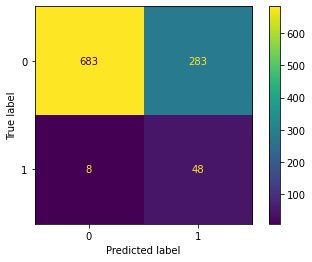

In [16]:
X_RFE = df_RFE.drop('stroke', axis=1)
y_RFE = df_RFE['stroke']
run_grid_search(X_RFE, y_RFE)

<h5>A model with default hyper-parameters run on the same data

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       966
           1       0.13      0.88      0.23        56

    accuracy                           0.69      1022
   macro avg       0.56      0.77      0.52      1022
weighted avg       0.94      0.69      0.77      1022



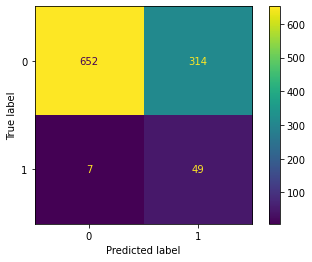

In [17]:
unoptimised_model = get_svc(class_weight = {0:0.05, 1:1})
run_model(unoptimised_model, X_RFE, y_RFE)

<h4>Optimised Model using DataFrame with Dummy Variables

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Optimised Hyper-parameters:  {'C': 2, 'cache_size': 100, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': 0}
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       966
           1       0.17      0.79      0.28        56

    accuracy                           0.78      1022
   macro avg       0.58      0.78      0.58      1022
weighted avg       0.94      0.78      0.84      1022



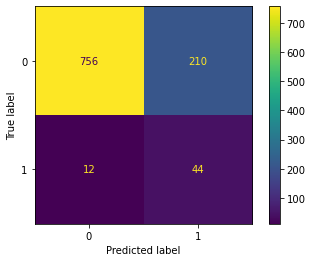

In [18]:
X_dummy = df_dummies.drop('stroke', axis=1)
y_dummy = df_dummies['stroke']

run_grid_search(X_dummy, y_dummy)

<h5>A model with default hyper-parameters run on the same data

              precision    recall  f1-score   support

           0       0.98      0.77      0.87       966
           1       0.16      0.77      0.27        56

    accuracy                           0.77      1022
   macro avg       0.57      0.77      0.57      1022
weighted avg       0.94      0.77      0.83      1022



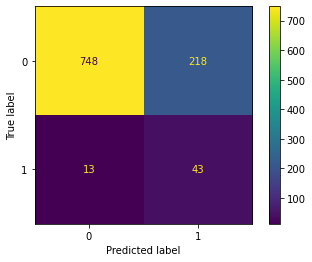

In [19]:
unoptimised_model = get_svc(class_weight={0:0.05, 1:1})
run_model(unoptimised_model, X_dummy, y_dummy)

<h4>Optimised Model using DataFrame with Age and Gender

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Optimised Hyper-parameters:  {'C': 10, 'cache_size': 100, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': 1}
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       966
           1       0.14      0.79      0.24        56

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.54      1022
weighted avg       0.94      0.73      0.80      1022



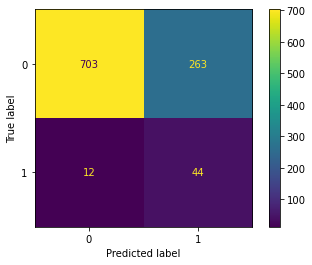

In [20]:
X_ag = df_age_gender.drop('stroke', axis=1)
y_ag = df_age_gender['stroke']
run_grid_search(X_ag, y_ag)

<h5>A model with default hyper-parameters run on the same data

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       966
           1       0.13      0.82      0.22        56

    accuracy                           0.69      1022
   macro avg       0.56      0.75      0.52      1022
weighted avg       0.94      0.69      0.77      1022



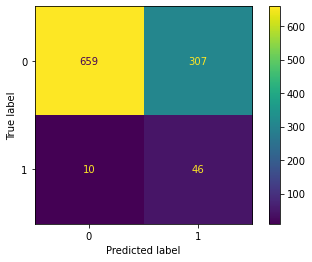

In [21]:
unoptimised_model = get_svc(class_weight={0:0.05, 1:1})
run_model(unoptimised_model, X_ag, y_ag)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Optimised Hyper-parameters:  {'C': 5, 'cache_size': 100, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': 1}
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       966
           1       0.15      0.84      0.25        56

    accuracy                           0.73      1022
   macro avg       0.57      0.78      0.54      1022
weighted avg       0.94      0.73      0.80      1022



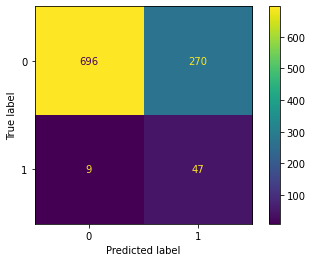

In [22]:
X_mix = df_mixed_norm.drop('stroke', axis=1)
y_mix = df_mixed_norm['stroke']

run_grid_search(X_mix, y_mix)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       966
           1       0.14      0.84      0.25        56

    accuracy                           0.72      1022
   macro avg       0.57      0.77      0.54      1022
weighted avg       0.94      0.72      0.79      1022



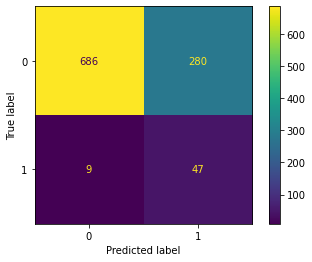

In [23]:
unoptimised_model = get_svc(class_weight={0:0.05, 1:1})
run_model(unoptimised_model, X_mix, y_mix)

<h4>Manual Grid Search using RFE features

In [24]:
def get_random_float(min, max):
    return min + (max-min)*random.random()
    
def get_cv_scores(model, X, y, n_splits=5,n_repeats=10, scoring=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    return cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
def get_metrics_score(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = {
        'recall':recall_score(y_test, y_pred, labels=np.unique(y_pred), zero_division=False),
        'f1':f1_score(y_test, y_pred, labels=np.unique(y_pred), zero_division=False),
        'roc':roc_auc_score(y_test, y_pred, labels=np.unique(y_pred)),
        'precision':precision_score(y_test, y_pred, labels=np.unique(y_pred), zero_division=False),
    }
    return scores

def get_reports_score(model, X, y):
    '''
    returns the recall, f1 and precision values obtained for the "1" class in a classification report
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    scores = {
        'recall':report['1']['recall'],
        'f1':report['1']['f1-score'],
        'precision':report['1']['precision'],
    }
    return scores

def check_if_better(old, new, thres=1.2):
    '''
    divides the new value by the old value and checks to see if this is greater than a threshold
    if new/old > 1, the new value is better than the old
    if new/old < 1, the new value is worse
    By setting the threshold, you can decide how much worse than the old is acceptable for the new value
    '''
    
    if old == 0:
        return True
    if(new/old > thres):
        return True
    
    return False

In [25]:
X = df_RFE.drop('stroke', axis=1)
y = df_RFE['stroke']


w1=0.05
w2=1

kernel = ['linear', 'rbf', 'sigmoid', 'poly']
gamma = ['scale','auto']
cache_sizes = [100, 200, 300, 400]
shrinking = [1, 0]
probability = [1,0]

# to stop the search from settling into a maximised recall position with no regard for other metrics
# shuffle all the arrays prior to starting to give the search a chance to seek out other combinations of hyper-parameters
np.random.shuffle(kernel)
np.random.shuffle(gamma)
np.random.shuffle(cache_sizes)
np.random.shuffle(shrinking)
np.random.shuffle(probability)

best = {
    'recall':0,
    'precision':0,
    'roc':0,
    'f1':0
}

best_cell = {}
cells = []
total_len = len(cache_sizes)*len(gamma)*len(kernel)*len(shrinking)*len(probability)
counter = 0

for k in kernel:
    for g in gamma:
        for s in shrinking:
            for p in probability:
                for cache in cache_sizes:
                    counter +=1

                    # it was found that the actual value of the weights isn't important, the ratio between the weights is the significant part

                    weights = {0:w1,1:w2}

                    svc = get_svc(cache_size=cache, class_weight = weights, kernel=k, gamma=g, shrinking=s, probability=p) 

                    scores = get_metrics_score(svc, X, y)

                    cell = {
                        'w1':w1,
                        'w2':w2,
                        'gamma':g,
                        'kernel':k,
                        'probability':p,
                        'shrinking':s,
                        'cache_size':cache,
                        'recall':scores['recall'],
                        'f1':scores['f1'],
                        'precision':scores['precision'],
                        'roc':scores['roc'],
                    }
                    clear_output(wait=True)

                    # only update the best cell if
                    # recall is better than the current best
                    # and roc_auc, precision or f1 isn't worse than 30% of its current best value
                    # this check is used so other metrics aren't minimized while we attempt to maximise our desired metric (recall)
                    if check_if_better(best['f1'], scores['f1'], 1.1) and check_if_better(best['roc'], scores['roc'], 0.9) and check_if_better(best['recall'], scores['recall'], 0.9):
                        best_cell = cell
                        best['recall'] = scores['recall']
                        best['f1'] = scores['f1']
                        best['precision'] = scores['precision']
                        best['roc']:scores['roc']

                        print(f"f1 score: {scores['f1']:.3f} - new best")
                    else:
                        print(f"f1 Score: {scores['f1']:.3f} - best f1 score is {best['f1']:.3f}")
                    print("Best cell:")
                    [print('\t', key, value, end="\n") for key, value in best_cell.items()]
                    print(f"Total complete: {100*(counter/total_len):.2f}%")
                    cells.append(cell)

f1 Score: 0.940 - best recall score is 0.860
Best cell:
	 w1 0.05
	 w2 1
	 gamma scale
	 kernel linear
	 probability 1
	 shrinking 0
	 cache_size 100
	 recall 0.86
	 f1 0.2369146005509642
	 precision 0.13738019169329074
	 roc 0.7911111111111111
Total complete: 100.00%


<h4>Model using hyperparameters found from manual grid search

Mean cv score 0.7044230839263912
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       966
           1       0.14      0.86      0.25        56

    accuracy                           0.71      1022
   macro avg       0.57      0.78      0.53      1022
weighted avg       0.94      0.71      0.79      1022



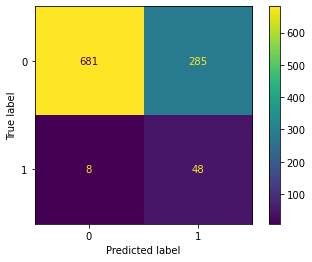

In [26]:
weight = {0: 0.05, 1: 1}
model = get_svc(weight, kernel=best_cell['kernel'], gamma=best_cell['gamma'], shrinking=best_cell['shrinking'], probability=best_cell['probability'], cache_size=best_cell['cache_size'])
cv_scores = get_cv_scores(model, X, y)
print("Mean cv score", np.mean(cv_scores))
run_model(model, X, y)